- Author: Peter Riesebos
- Purpose: Script used to combine filtered eQTL and GWAS sum stats as preparation for colocalization analysis, also inspects the output data and shows graphs of the data
- Input: filtered eQTL sum stat files, filtered GWAS sum stat files and colocalization output files
- Output: combined eQTL and GWAS sum stat files, used as input for running coloc. Graphs plotting the output from colocalization

# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import logging
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import pearsonr

# Final coloc prep step

In [ ]:
# This last step writes out a file for each gene that will be used for colocalization, based on the GWAS significant treshold cut-off
# and a minimum of 200 variants for a gene cut-off, output from the earlier coloc steps used as input.

# Define file patterns and output directory
gwas_file_pattern = "/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GWAS/GCST90292538.h_filtered_eQTLSNPs_200kb-chr*.tsv.gz"
eqtl_file_pattern = "/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/combined/mbqtl_output_combined_exp_fixed/combined_chr*-AllEffects_200kb_significant.txt.gz"

# Define the output directory
output_dir = "/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/combined/coloc_files"

# Set up logging to log progress
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
logger = logging.getLogger()

# Get lists of GWAS and eQTL files
gwas_files = sorted(glob.glob(gwas_file_pattern))
eqtl_files = sorted(glob.glob(eqtl_file_pattern))

# Create a mapping of chromosome to files
gwas_chr_files = {int(file.split('-chr')[1].split('.')[0]): file for file in gwas_files}
eqtl_chr_files = {int(file.split('_chr')[1].split('-')[0]): file for file in eqtl_files}

def process_gene_group(gene, eqtl_combined_subset, gwas_df):
    """
    Process a single gene group: Merge, filter, and save results if conditions are met.
    """
    # Merge eQTL data for the gene with GWAS data based on SNP/rsid
    df_for_coloc = pd.merge(eqtl_combined_subset, gwas_df, left_on="SNP", right_on="rsid", how="inner")
    
    # Remove duplicate SNP entries, keeping the first occurrence
    df_for_coloc_filtered = df_for_coloc.drop_duplicates(subset="SNP", keep="first")
    
    # Check the number of significant p-values
    length_coloc_df = df_for_coloc_filtered[df_for_coloc_filtered["p_value"] <= 5e-8].shape[0]
    
    # Condition to check if the filtered dataframe meets both criteria
    if length_coloc_df > 0 and df_for_coloc_filtered["SNP"].size > 200:
        # Define a filename for output based on the gene name
        output_filename = os.path.join(output_dir, f"chr{chr_num}_{gene}_coloc_results.tsv")
        
        # Save the DataFrame to a TSV file
        df_for_coloc_filtered.to_csv(output_filename, sep='\t', index=False)

def process_chromosome(chr_num):
    """
    Process a single chromosome by reading GWAS and eQTL files and processing gene groups.
    """
    # Read the corresponding GWAS and eQTL files for this chromosome
    gwas_df = pd.read_csv(gwas_chr_files[chr_num], sep='\t')  # Read GWAS file
    eqtl_df = pd.read_csv(eqtl_chr_files[chr_num], sep='\t')  # Read eQTL file

    # Get the total number of unique genes for this chromosome
    total_genes = eqtl_df["Gene"].nunique()
    logger.info(f"Processing chromosome {chr_num}... Total genes: {total_genes}")

    # Group eQTL data by Gene
    eqtl_grouped = eqtl_df.groupby("Gene")

    # Track progress within the chromosome
    with ThreadPoolExecutor() as executor:
        futures = []
        for idx, (gene, eqtl_combined_subset) in enumerate(eqtl_grouped):
            futures.append(
                executor.submit(process_gene_group, gene, eqtl_combined_subset, gwas_df)
            )
            # Log progress every 10 genes
            if (idx + 1) % 10 == 0 or (idx + 1) == total_genes:
                logger.info(f"Chromosome {chr_num}: Processed {idx + 1}/{total_genes} genes")

        # Ensure all threads complete
        for future in futures:
            future.result()  # Ensure all tasks complete

# Process each chromosome sequentially
for chr_num in sorted(gwas_chr_files.keys()):
    process_chromosome(chr_num)

# coloc_output inspection

In [2]:
# Directory containing my files
directory_path = "/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/combined/coloc_output"

# Use glob to get all file paths (adjust the pattern for your file type)
file_paths = glob.glob(f"{directory_path}/*.tsv.txt")  # Change "*.csv" to match your file type, e.g., "*.tsv"

# Initialize an empty list to hold DataFrames
dataframes = []

# Read each file into a DataFrame and append it to the list
for file_path in file_paths:
    df = pd.read_csv(file_path, sep='\t')  # Adjust for the file format, e.g., pd.read_table for TSV
    dataframes.append(df)

# Combine all DataFrames into one
coloc_results = pd.concat(dataframes, ignore_index=True)

# Output the combined DataFrame
coloc_results

,gennaam,gensymbol,PP3,PP4,top_GWAS_SNP,top_GWAS_pvalue,top_eQTL_SNP,top_eQTL_pvalue,distance_top_SNPs,distance_top_GWAS_to_TSS,distance_top_eQTL_to_TSS
0,ENSG00000223865,ENSG00000223865,0.980847,6.097875e-04,rs73415247,5.399000e-33,rs9277053,3.790709e-07,22983,14562,37545
1,ENSG00000169682,ENSG00000169682,0.387843,1.548134e-01,rs8049439,1.403000e-19,rs7189056,6.685463e-05,284532,148027,136505
2,ENSG00000181004,ENSG00000181004,0.994926,1.560247e-04,rs62322747,7.875000e-19,rs309365,2.449553e-08,202886,197400,5486
3,ENSG00000204568,ENSG00000204568,0.087543,5.522236e-02,rs4713380,1.042000e-11,rs3734843,2.607040e-03,331478,199656,131822
4,ENSG00000166847,ENSG00000166847,0.998436,8.094695e-06,rs3900007,6.035000e-09,rs62032983,6.159442e-157,193609,194165,556
...,...,...,...,...,...,...,...,...,...,...,...
690,ENSG00000108771,ENSG00000108771,1.000000,3.972503e-15,rs6503694,8.459000e-24,rs4796772,4.345987e-48,182910,197941,15031
691,ENSG00000197057,ENSG00000197057,0.039892,5.000988e-02,rs4492027,1.192000e-08,rs12646644,2.051376e-02,113830,91804,22026
692,ENSG00000158987,ENSG00000158987,0.864849,9.478295e-03,rs11950815,4.960000e-18,rs171536,1.042571e-05,274455,195873,78582
693,ENSG00000111271,ENSG00000111271,0.609969,1.781011e-01,rs11065991,3.503000e-11,rs678436,1.404051e-05,133768,40695,174463


In [3]:
filtered_rows = coloc_results[coloc_results["PP4"] > 0.8]
row_count = filtered_rows.shape[0]
row_count

48

In [44]:
filtered_rows

,gennaam,gensymbol,PP3,PP4,top_GWAS_SNP,top_GWAS_pvalue,top_eQTL_SNP,top_eQTL_pvalue,distance_top_SNPs,distance_top_GWAS_to_TSS,distance_top_eQTL_to_TSS
6,ENSG00000037042,ENSG00000037042,0.008613,0.991379,rs4793090,3.784000e-16,rs4793090,7.252530e-09,0,124960,124960
15,ENSG00000086589,ENSG00000086589,0.095091,0.810799,rs7709388,1.169000e-31,rs112321295,4.368274e-05,9995,176185,186180
23,ENSG00000146535,ENSG00000146535,0.061864,0.938136,rs798500,2.920000e-13,rs798526,2.250366e-21,15143,22946,7803
24,ENSG00000085978,ENSG00000085978,0.081795,0.918205,rs13009506,2.894000e-33,rs35174053,7.635242e-19,21692,57009,35317
45,ENSG00000213221,ENSG00000213221,0.093101,0.817157,rs3812565,3.222000e-37,rs3812556,6.487777e-06,10511,18570,8059
49,ENSG00000169220,ENSG00000169220,0.018116,0.981884,rs10051765,1.238000e-14,rs56235845,8.487012e-34,1952,15067,13115
53,ENSG00000175164,ENSG00000175164,0.035142,0.964467,rs1345832986,2.974000e-08,rs8176719,3.109084e-81,8571,32814,24243
77,ENSG00000204681,ENSG00000204681,0.101353,0.894157,rs7754067,1.526000e-15,rs4391284,2.061420e-07,54793,177113,122320
78,ENSG00000117505,ENSG00000117505,0.067889,0.932081,rs10874777,2.308000e-09,rs12133576,1.795249e-26,45620,50556,4936
79,ENSG00000157873,ENSG00000157873,0.067926,0.930412,rs1886730,1.277000e-10,rs2227312,2.016769e-07,945,1530,585


In [4]:
coloc_results[coloc_results["gennaam"]== "ENSG00000128604"]

,gennaam,gensymbol,PP3,PP4,top_GWAS_SNP,top_GWAS_pvalue,top_eQTL_SNP,top_eQTL_pvalue,distance_top_SNPs,distance_top_GWAS_to_TSS,distance_top_eQTL_to_TSS
425,ENSG00000128604,ENSG00000128604,0.001052,0.998935,rs3757387,4.352000e-09,rs3757387,1.425636e-46,0,1425,1425


In [5]:
highest_pp_gene = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/combined/coloc_files_newest/chr7_ENSG00000128604_coloc_results.tsv", sep='\t')

In [14]:
highest_pp_gene

,Gene,GeneChr,GenePos,GeneStrand,GeneSymbol,SNP,SNPChr,SNPPos,SNPAlleles,SNPEffectAllele,...,FreqSE,MinFreq,MaxFreq,Direction,HetISq,HetChiSq,HetDf,HetPVal,hm_coordinate_conversion,hm_code
0,ENSG00000128604,7,128937457,+,ENSG00000128604,rs10243219,7,128737463,C/T,T,...,0.0269,0.0073,0.2654,+?++-+,0.0,3.907,4,0.4188,lo,10
1,ENSG00000128604,7,128937457,+,ENSG00000128604,rs60425056,7,128737511,C/T,T,...,0.0166,0.0128,0.0955,-?+++-,0.0,2.886,4,0.5771,lo,10
2,ENSG00000128604,7,128937457,+,ENSG00000128604,rs7795071,7,128739155,G/T,T,...,0.0271,0.0069,0.2669,+?++++,0.0,3.316,4,0.5064,lo,10
3,ENSG00000128604,7,128937457,+,ENSG00000128604,rs4731513,7,128739941,A/G,G,...,0.0582,0.0214,0.3918,-?++--,0.0,3.560,4,0.4688,lo,10
4,ENSG00000128604,7,128937457,+,ENSG00000128604,rs6967300,7,128740085,G/T,T,...,0.0272,0.0070,0.2667,-?++-+,0.0,3.786,4,0.4358,lo,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,ENSG00000128604,7,128937457,+,ENSG00000128604,rs28396650,7,129130647,G/A,A,...,0.0140,0.1547,0.2046,+----+,28.0,6.945,5,0.2248,lo,10
728,ENSG00000128604,7,128937457,+,ENSG00000128604,rs112310218,7,129135710,C/T,T,...,0.0312,0.0099,0.2217,?+?++-,0.0,2.732,3,0.4348,lo,10
729,ENSG00000128604,7,128937457,+,ENSG00000128604,rs74678676,7,129137123,G/A,A,...,0.0167,0.0437,0.1066,--++++,5.6,5.296,5,0.3808,lo,10
730,ENSG00000128604,7,128937457,+,ENSG00000128604,rs6944667,7,129137238,G/A,A,...,0.0173,0.7104,0.7649,+++---,0.0,3.456,5,0.6300,lo,10


In [8]:
highest_pp_gene["log10MetaP"] = -np.log10(highest_pp_gene["MetaP"])

In [9]:
highest_pp_gene["log10GWASP"] = -np.log10(highest_pp_gene["p_value"])

# Graphs

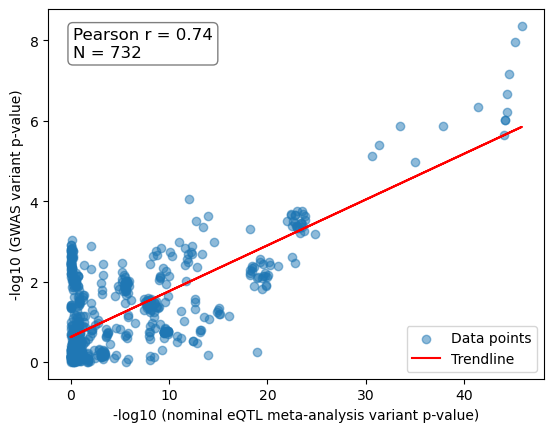

In [11]:
# Scatter plot
plt.scatter(highest_pp_gene["log10MetaP"], highest_pp_gene["log10GWASP"], label="Data points", alpha=0.5)
plt.xlabel("-log10 (nominal eQTL meta-analysis variant p-value)")
plt.ylabel("-log10 (GWAS variant p-value)")

# Calculate trendline
x = highest_pp_gene["log10MetaP"]
y = highest_pp_gene["log10GWASP"]
coefficients = np.polyfit(x, y, 1)  # Fit a line (degree=1)
trendline = np.poly1d(coefficients)  # Create a trendline function

# Calculate Pearson correlation
correlation, _ = pearsonr(x, y)

# Count the number of points
num_points = len(x)

# Add the trendline
plt.plot(x, trendline(x), color="red", label="Trendline")

# Add combined annotation for Pearson correlation and number of points
plt.text(
    0.05, 0.95,  # Coordinates in the axes fraction (5% from left, 95% from top)
    f"Pearson r = {correlation:.2f}\nN = {num_points}",
    transform=plt.gca().transAxes,  # Use axes coordinates for placement
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)  # Add a background box
)

# Add a legend
plt.legend()

# Show the plot
plt.show()


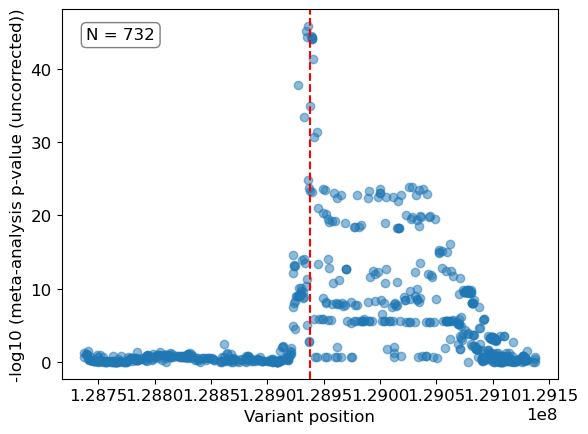

In [17]:
    plt.scatter(highest_pp_gene["SNPPos"], highest_pp_gene["log10MetaP"], alpha=0.5)
    plt.axvline(x=highest_pp_gene["GenePos"][0], color='r', linestyle="dashed")
    plt.xlabel("Variant position")
    plt.ylabel("-log10 (meta-analysis p-value (uncorrected))")

    # Add number of points as an annotation
    num_points_meta = len(highest_pp_gene)
    plt.text(
        0.05, 0.95,  # Coordinates in the axes fraction (5% from left, 95% from top)
        f"N = {num_points_meta}",
        transform=plt.gca().transAxes,  # Use axes coordinates for placement
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)  # Add a background box
    )

    plt.show()

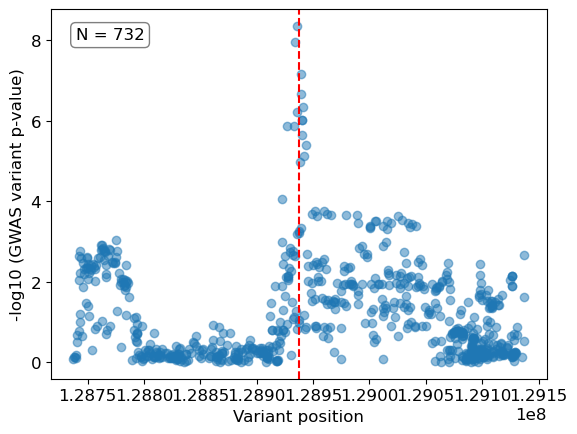

In [18]:
plt.scatter(highest_pp_gene["SNPPos"], highest_pp_gene["log10GWASP"], alpha=0.5)
plt.axvline(x=highest_pp_gene["GenePos"][0], color='r', linestyle="dashed")
plt.xlabel("Variant position")
plt.ylabel("-log10 (GWAS variant p-value)")

# Add number of points as an annotation
num_points_gwas = len(highest_pp_gene)
plt.text(
    0.05, 0.95,  # Coordinates in the axes fraction (5% from left, 95% from top)
    f"N = {num_points_gwas}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)  # Add a background box
)

plt.show()

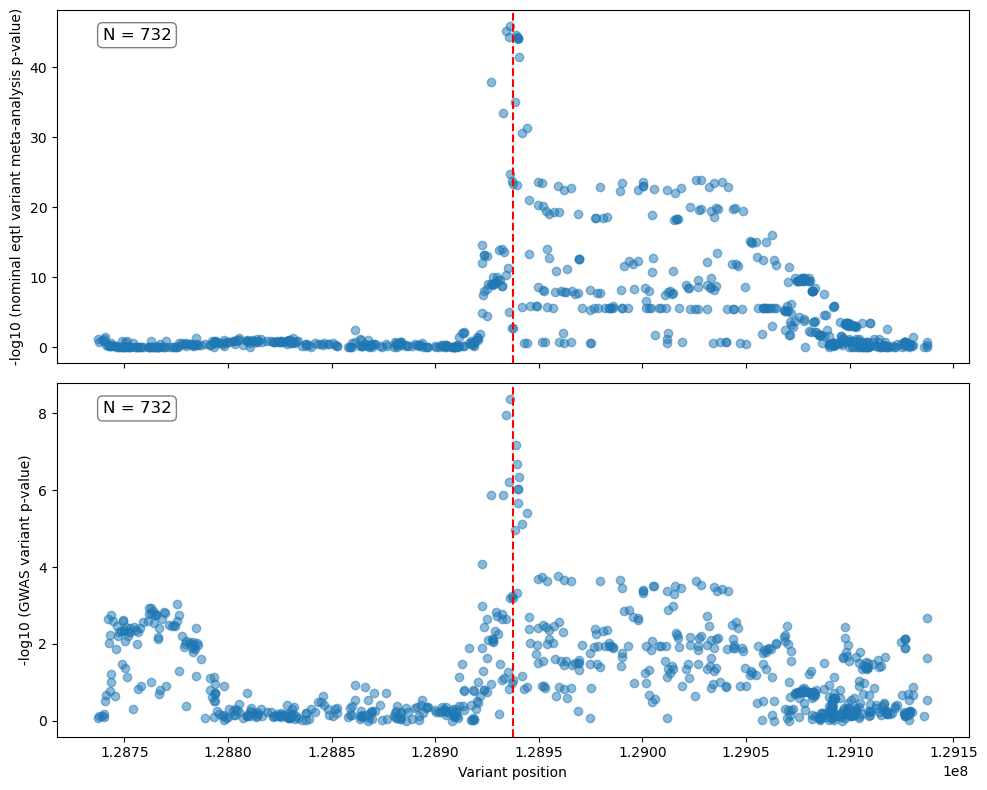

In [ ]:
# set font size
plt.rcParams.update({'font.size': 10})

# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1]})

# First plot (meta-analysis p-values)
ax1.scatter(highest_pp_gene["SNPPos"], highest_pp_gene["log10MetaP"], alpha=0.5)
ax1.axvline(x=highest_pp_gene["GenePos"][0], color='r', linestyle="dashed")
ax1.set_ylabel("-log10 (nominal eqtl variant meta-analysis p-value)")
num_points_meta = len(highest_pp_gene["SNPPos"])
ax1.text(0.05, 0.95, f"N = {num_points_meta}", transform=ax1.transAxes, fontsize=12, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Second plot (GWAS variant p-values)
ax2.scatter(highest_pp_gene["SNPPos"], highest_pp_gene["log10GWASP"], alpha=0.5)
ax2.axvline(x=highest_pp_gene["GenePos"][0], color='r', linestyle="dashed")
ax2.set_xlabel("Variant position")
ax2.set_ylabel("-log10 (GWAS variant p-value)")
num_points_gwas = len(highest_pp_gene["SNPPos"])
ax2.text(0.05, 0.95, f"N = {num_points_gwas}", transform=ax2.transAxes, fontsize=12, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


In [4]:
# look up corresponding gene names for each gene
# Load the GTF file into a pandas DataFrame
gtf_file = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/references/gencode_44_2023/gencode.v44.primary_assembly.annotation.gtf'
gtf_df = pd.read_csv(gtf_file, sep='\t', comment='#', header=None, 
                     names=["chrom", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"])

# Extract gene_id and gene_name
gtf_df['gene_id'] = gtf_df['attribute'].str.extract('gene_id "([^"]+)"')[0].str.split('.').str[0]
gtf_df['gene_name'] = gtf_df['attribute'].str.extract('gene_name "([^"]+)"')[0]

# Filter for only the gene rows (feature type is 'gene')
gene_df = gtf_df[gtf_df['feature'] == 'gene']

# List of ENSG gene IDs you want to match (without version number)
ensg_ids = ["ENSG00000037042", "ENSG00000086589", "ENSG00000146535", "ENSG00000085978", 
            "ENSG00000213221", "ENSG00000169220", "ENSG00000175164", "ENSG00000204681", 
            "ENSG00000117505", "ENSG00000157873", "ENSG00000188603", "ENSG00000184730", 
            "ENSG00000242485", "ENSG00000164308", "ENSG00000143452", "ENSG00000095110", 
            "ENSG00000107882", "ENSG00000101311", "ENSG00000141646", "ENSG00000076043", 
            "ENSG00000205726", "ENSG00000185651", "ENSG00000163374", "ENSG00000174306", 
            "ENSG00000157870", "ENSG00000055130", "ENSG00000128604", "ENSG00000115607", 
            "ENSG00000137634", "ENSG00000164062", "ENSG00000117500", "ENSG00000127054", 
            "ENSG00000130518", "ENSG00000064419", "ENSG00000178952", "ENSG00000168071", 
            "ENSG00000161180", "ENSG00000198156", "ENSG00000188322", "ENSG00000178149", 
            "ENSG00000072786", "ENSG00000264058", "ENSG00000196993", "ENSG00000086544", 
            "ENSG00000162576", "ENSG00000196296", "ENSG00000122483", "ENSG00000131584"]

# Filter gene_df to keep only the rows with matching ENSG gene IDs
matched_genes = gene_df[gene_df['gene_id'].isin(ensg_ids)]

# Display the matched gene names
matched_genes[['gene_id', 'gene_name']]


,gene_id,gene_name
3455,ENSG00000131584,ACAP3
3720,ENSG00000127054,INTS11
4692,ENSG00000162576,MXRA8
5161,ENSG00000242485,MRPL20
10609,ENSG00000157873,TNFRSF14
10788,ENSG00000157870,PRXL2B
143815,ENSG00000117500,TMED5
143874,ENSG00000122483,CCDC18
144588,ENSG00000117505,DR1
189588,ENSG00000143452,HORMAD1


Number of rows: 48


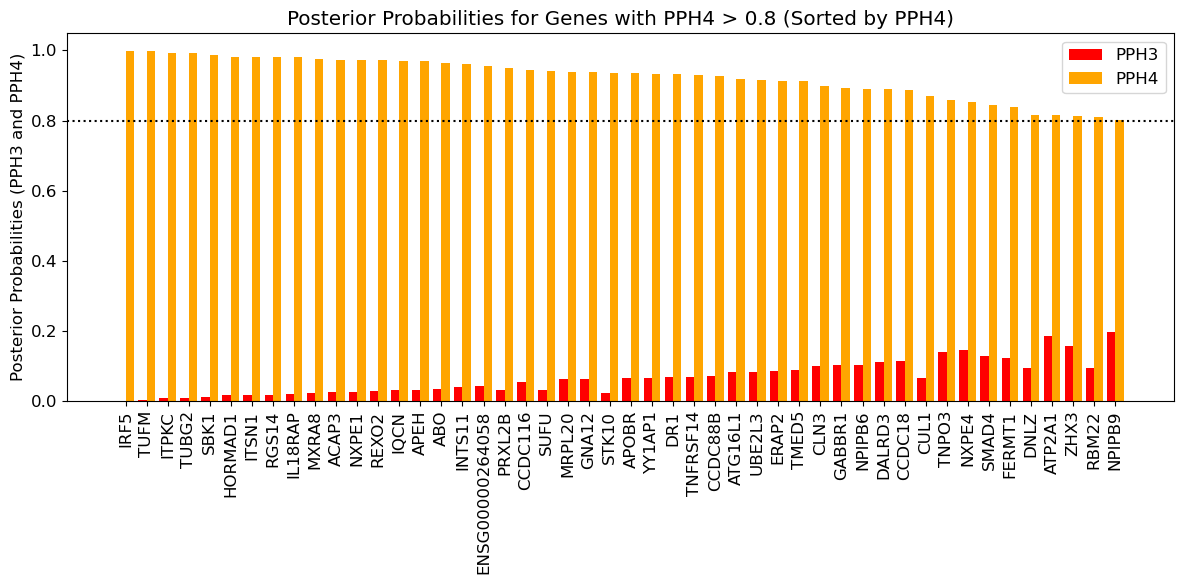

In [11]:
plt.rcParams.update({'font.size': 12})

# Filter for rows with PP4 > 0.8 and sort by PP4 in descending order
filtered_rows = coloc_results[coloc_results["PP4"] > 0.8].sort_values(by="PP4", ascending=False)

# Number of rows filtered
row_count = filtered_rows.shape[0]
print(f"Number of rows: {row_count}")

# Extract sorted data
genes = filtered_rows["gennaam"].values  # Gene ID column
pp3_values = filtered_rows["PP3"].values
pp4_values = filtered_rows["PP4"].values

# Map gene IDs to gene names using the matched_genes DataFrame
gene_names = [matched_genes.loc[matched_genes['gene_id'] == gene, 'gene_name'].values[0] if not matched_genes.loc[matched_genes['gene_id'] == gene, 'gene_name'].empty else "Unknown" for gene in genes]

# Create a bar chart
x = np.arange(len(genes))  # Create a range for x-axis positions
width = 0.4  # Width of each bar

plt.figure(figsize=(12, 6))
plt.bar(x - width / 2, pp3_values, width, label="PPH3", color="red")
plt.bar(x + width / 2, pp4_values, width, label="PPH4", color="orange")
plt.axhline(0.8, color="black", linestyle="dotted")
# plt.axhline(0.2, color="black", linestyle="dotted")

# Add labels and title
# plt.xlabel("Gene")
plt.ylabel("Posterior Probabilities (PPH3 and PPH4)")
plt.title("Posterior Probabilities for Genes with PPH4 > 0.8 (Sorted by PPH4)")
plt.xticks(x, gene_names, rotation=90)  # Replace with gene names, rotate for readability
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()